<a href="https://www.kaggle.com/code/babaksh/rice-classification-pytorch?scriptVersionId=261878529" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Rice Image Dataset

## **Overview**
The **Rice Image Dataset** is a collection of high-resolution images designed for rice grain classification. It contains images of five different rice varieties, making it useful for machine learning applications in agricultural research, food quality assessment, and automated classification systems.

## **Dataset Details**
- **Total Images**: 75,000  
- **Number of Classes**: 5  
- **Image Size**: 250 × 250 pixels  
- **Format**: JPEG  
- **Grayscale or RGB**: RGB  

## **Classes (Rice Varieties)**
The dataset includes images of the following five types of rice grains:  
1. **Arborio**  
2. **Basmati**  
3. **Ipsala**  
4. **Jasmine**  
5. **Karacadag**  

Each class contains an equal number of images, ensuring balanced data for training machine learning models.

## **Potential Use Cases**
- **Classification Models**: Train deep learning models (e.g., CNNs, ViTs) to classify rice varieties.
- **Feature Extraction**: Extract texture, shape, and color features for distinguishing different rice types.
- **Quality Assessment**: Identify high-quality vs. low-quality grains using automated inspection systems.
- **Agricultural Research**: Analyze grain characteristics to improve production and processing techniques.


# Code Overview

This code imports essential libraries for building and training an image classification model using PyTorch.

- **os, numpy, pandas**: For data management and numerical operations.
- **seaborn, matplotlib**: For data visualization and plotting.
- **torch**: Core framework for deep learning tasks, including model building and training.
- **sklearn**: For splitting data and dimensionality reduction (t-SNE).
- **ImageDataGenerator**: For real-time data augmentation.
- **Callbacks (EarlyStopping, ModelCheckpoint)**: To improve training by monitoring performance.

These libraries help preprocess data, define the model, optimize training, and visualize results.


In [1]:
import os
import copy
import torch
import random
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# Image Parameters and Dataset Path

In this step, we define key parameters for preprocessing and model training:

- **Image Size**: Resized to `(224, 224)` for consistency across the dataset.
- **Channels**: Set to `3` (RGB), ensuring compatibility with deep learning models.
- **Batch Size**: `64`, balancing memory usage and training efficiency.
- **Epochs**: `15`, defining the number of training iterations.
- **Learning Rate**: `1e-3`, a standard starting point for optimization.
- **Patience**: `10`, allowing early stopping if validation performance does not improve.

The dataset path is set to the **Rice Image Dataset** location on Kaggle.

In [3]:
# Image parameters
IMG_SIZE = (224, 224)
CHANNELS = 3
BATCH_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 1e-3
PATIENCE = 10

# Paths
dataset_path = "/kaggle/input/Rice_Image_Dataset"

# Data transforms

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data Visualization

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


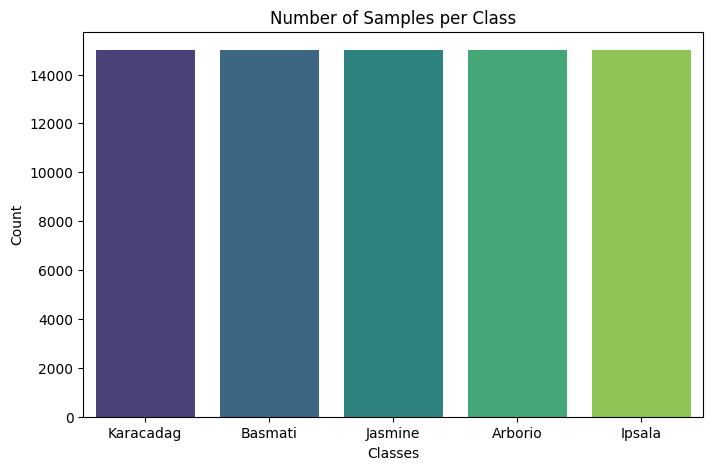

In [5]:
# Get only class folders
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Show class distribution
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes}

plt.figure(figsize=(8,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.title("Number of Samples per Class")
plt.ylabel("Count")
plt.xlabel("Classes")
plt.show()

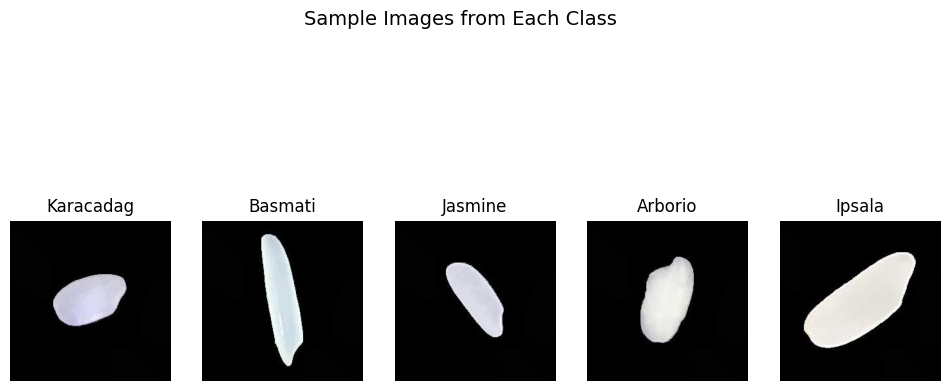

In [6]:
# Show sample images from each class
plt.figure(figsize=(12, 6))
for i, cls in enumerate(classes):
    img_path = os.path.join(dataset_path, cls, random.choice(os.listdir(os.path.join(dataset_path, cls))))
    img = Image.open(img_path)
    plt.subplot(1, len(classes), i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
plt.suptitle("Sample Images from Each Class", fontsize=14)
plt.show()

# Data Preparation: Train, Validation, and Test Loaders

This step loads the **Rice Image Dataset** and splits it into **training, validation, and test sets** using `torchvision.datasets.ImageFolder()` and `torch.utils.data.random_split()`.

- **Training Set** (`train_loader`): 
  - 70% of the dataset.
  - Labels are automatically inferred from folder structure and converted to integer indices.
  - Images are resized to `(224, 224)` with data augmentation transforms (random flip, rotation, color jitter).
  - Normalized using ImageNet statistics `([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])`.
  - Batch size is `64` with shuffling enabled.

- **Validation Set** (`val_loader`):  
  - 20% of the dataset.
  - Used to monitor model performance during training.
  - Only basic transforms applied (resize, normalize) without augmentation.

- **Test Set** (`test_loader`):  
  - 10% of the dataset, separate from validation.
  - Used for final evaluation.
  - Same transforms as validation set.



In [7]:
# Load datasets
train_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=dataset_path, transform=val_transforms)
test_dataset = datasets.ImageFolder(root=dataset_path, transform=val_transforms)

In [8]:
# Split datasets
train_size = int(0.7 * len(train_dataset))
val_size = int(0.2 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size

In [9]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(1000)
)

In [10]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# CNN Model Architecture

This Convolutional Neural Network (CNN) is designed for image classification and consists of three convolutional blocks followed by a classification block.

- **First Convolutional Block**: 
  - Uses a 32-filter `Conv2D` layer with a `3x3` kernel and ReLU activation.
  - Applies `BatchNormalization` to stabilize training.
  - Uses `MaxPooling2D` to reduce spatial dimensions.
  - Includes `Dropout (0.3)` to prevent overfitting.

- **Second Convolutional Block**:
  - Expands to 64 filters with similar layers as the first block.
  - `Dropout (0.4)` is used for regularization.

- **Third Convolutional Block**:
  - Uses 128 filters, `BatchNormalization`, and ReLU activation.
  - `MaxPooling2D` downsamples features.
  - `Dropout (0.5)` helps prevent overfitting.

- **Classification Block**:
  - `GlobalAveragePooling2D` followed by `Flatten` reduces feature maps.
  - Fully connected (`Dense`) layers progressively reduce dimensions: `512 → 256 → 128`.
  - `BatchNormalization` and `Dropout` (up to 0.7) improve generalization.
  - Final `Dense` layer with `softmax` activation outputs class probabilities.

This model balances depth and regularization for robust feature extraction and classification.

In [11]:
# CNN Model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        
        # First Convolutional Block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.3)
        
        # Second Convolutional Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.4)
        
        # Third Convolutional Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.5)
        
        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Classification Block
        self.fc1 = nn.Linear(128, 512)
        self.dropout4 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(512, 256)
        self.dropout5 = nn.Dropout(0.65)
        self.fc3 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout6 = nn.Dropout(0.7)
        self.fc4 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second block
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third block
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Global average pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # Classification
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = F.relu(self.fc2(x))
        x = self.dropout5(x)
        x = F.relu(self.fc3(x))
        x = self.bn4(x)
        x = self.dropout6(x)
        x = self.fc4(x)
        
        return x

# AlexNet Model Architecture

This function implements a variant of the **AlexNet** architecture for image classification, modified for use with PyTorch.

- **Input & Preprocessing**:
  - The input is resized to `227x227` to match the original AlexNet dimensions.

- **Feature Extraction (Convolutional Blocks)**:
  - **Block 1**: Uses a `96-filter` convolutional layer with an `11x11` kernel, `stride 4`, followed by `MaxPooling` and `BatchNormalization`.
  - **Block 2**: Expands to `256 filters` with a `5x5` kernel, `same padding`, followed by `MaxPooling` and `BatchNormalization`.
  - **Block 3**: Uses `384 filters` with a `3x3` kernel.
  - **Block 4**: Another `384-filter` convolutional layer with a `3x3` kernel.
  - **Block 5**: Uses `256 filters` with a `3x3` kernel, followed by `MaxPooling`.

- **Classification (Fully Connected Layers)**:
  - `GlobalAveragePooling2D` and `Flatten` prepare features for dense layers.
  - Two fully connected layers with `4096` neurons and `ReLU` activation.
  - `Dropout (0.5)` helps prevent overfitting.
  - A final `Dense` layer with `softmax` activation outputs class probabilities.

This architecture is optimized for large-scale image classification, leveraging deep convolutional layers and fully connected layers for robust feature learning.

In [12]:
# AlexNet Model
class AlexNetModel(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetModel, self).__init__()
        
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(96),
            
            # Block 2
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(256),
            
            # Block 3
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # Block 4
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # Block 5
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        # Resize to 227x227 for AlexNet
        x = F.interpolate(x, size=(227, 227), mode='bilinear', align_corners=False)
        x = self.features(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# ResNet50 Model Architecture

This function builds a **ResNet50-based** model for image classification using transfer learning.

- **Base Model (ResNet50)**:
  - Loads a pre-trained `ResNet50` model with `ImageNet` weights.
  - `include_top=False` removes the original fully connected layers.
  - `trainable=False` freezes the base model to retain learned features.

- **Preprocessing & Feature Extraction**:
  - Input is resized to `224x224` to match ResNet50's expected dimensions.
  - Uses `tf.keras.applications.resnet50.preprocess_input()` for standardization.
  - The base model extracts deep hierarchical features.

- **Classification Head**:
  - `GlobalAveragePooling2D` reduces the feature maps to a single vector.
  - A `Dense (256 units, ReLU)` layer captures high-level representations.
  - `Dropout (0.5)` prevents overfitting.
  - The final `Dense` layer with `softmax` activation outputs class probabilities.

This approach leverages **ResNet50's** powerful feature extraction while adding a custom classification head for adaptation to new datasets.


In [13]:
# ResNet50 Model
def build_resnet50_model(num_classes):
    model = models.resnet50(pretrained=True)
    
    # Freeze base model
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace classifier
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )
    
    return model

# Determining Number of Classes and Input Shape
- **Number of Classes**: Extracted from `full_dataset.classes` using `len(full_dataset.classes)`, representing the five rice grain categories in the dataset.  
- **Class Names**: Stored in `classes` variable from `full_dataset.classes`, listing all unique categories.  
- **Input Shape**: Defined as `(3, 224, 224)` in PyTorch format (channels-first), matching the RGB channels and resized image dimensions.

These values will be used to configure the model architecture for classification.


In [14]:
# Get number of classes and class names
full_dataset = datasets.ImageFolder(root=dataset_path)
num_classes = len(full_dataset.classes)
classes = full_dataset.classes
input_shape = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)
print(f'Number of classes: {num_classes}')
print(f'Classes: {classes}')
print(f'Input Shape: {input_shape}')

Number of classes: 5
Classes: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
Input Shape: (224, 224, 3)


# Training the CNN, AlexNet, and ResNet50 Models
Each model is trained using the custom **train_model()** function with the following settings:
- **Training Data**: `train_loader`
- **Validation Data**: `val_loader`
- **Epochs**: `15` (or until early stopping is triggered)
- **Optimizer**: Adam optimizer with learning rate `1e-3`
- **Loss Function**: CrossEntropyLoss for multi-class classification
- **Training Features**:
  - **Early Stopping**: Stops training if validation accuracy does not improve for `PATIENCE` epochs.
  - **Model Checkpoint**: Saves the best model state dict based on validation accuracy to `.pth` files.
  - **Device Management**: Automatically uses GPU if available, otherwise CPU.

The training process generates history dictionaries (`cnn_history`, `alexnet_history`, and `resnet_history`), which store performance metrics like loss and accuracy for both training and validation phases for further analysis.


In [15]:
# Training function
def train_model(model, train_loader, val_loader, num_epochs, model_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    patience_counter = 0
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.cpu())
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
        
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
        
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc.cpu())
        
        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
        
        # Early stopping and model checkpoint
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f'best_{model_name}.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= PATIENCE:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
        
        print()
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    history = {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'val_loss': val_losses,
        'val_acc': val_accs
    }
    
    return model, history

In [16]:
# Build models
cnn_model = CNNModel(num_classes)
print("CNN Model Summary:")
print(cnn_model)

CNN Model Summary:
CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.4, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.5, inplace=False)
  (global_pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_feature

In [17]:
alexnet_model = AlexNetModel(num_classes)
print("\nAlexNet Model Summary:")
print(alexnet_model)


AlexNet Model Summary:
AlexNetModel(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_pool): AdaptiveAvgPool2d(output_size=1)

In [18]:
resnet50_model = build_resnet50_model(num_classes)
print("\nResNet50 Model Summary:")
print(resnet50_model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]



ResNet50 Model Summary:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel

In [19]:
# Train CNN model
print("Training CNN Model...")
cnn_model, cnn_history = train_model(cnn_model, train_loader, val_loader, EPOCHS, 'cnn')

Training CNN Model...
Epoch 1/15
----------
Train Loss: 1.3272 Acc: 0.3869
Val Loss: 1.1571 Acc: 0.4066

Epoch 2/15
----------
Train Loss: 1.1812 Acc: 0.4405
Val Loss: 1.1059 Acc: 0.4483

Epoch 3/15
----------
Train Loss: 1.1280 Acc: 0.4805
Val Loss: 0.9985 Acc: 0.5772

Epoch 4/15
----------
Train Loss: 1.1018 Acc: 0.4988
Val Loss: 1.0674 Acc: 0.4821

Epoch 5/15
----------
Train Loss: 1.0708 Acc: 0.5115
Val Loss: 0.9480 Acc: 0.6131

Epoch 6/15
----------
Train Loss: 1.0556 Acc: 0.5241
Val Loss: 0.9248 Acc: 0.6285

Epoch 7/15
----------
Train Loss: 1.0092 Acc: 0.5550
Val Loss: 10.0921 Acc: 0.2037

Epoch 8/15
----------
Train Loss: 0.9964 Acc: 0.5679
Val Loss: 0.8598 Acc: 0.6273

Epoch 9/15
----------
Train Loss: 1.0040 Acc: 0.5720
Val Loss: 0.8373 Acc: 0.6430

Epoch 10/15
----------
Train Loss: 0.9781 Acc: 0.5847
Val Loss: 0.8301 Acc: 0.6418

Epoch 11/15
----------
Train Loss: 0.9591 Acc: 0.6007
Val Loss: 0.7958 Acc: 0.7321

Epoch 12/15
----------
Train Loss: 0.9153 Acc: 0.6363
Val Loss

In [20]:
# Train AlexNet model
print("Training AlexNet Model...")
alexnet_model, alexnet_history = train_model(alexnet_model, train_loader, val_loader, EPOCHS, 'alexnet')

Training AlexNet Model...
Epoch 1/15
----------
Train Loss: 0.3483 Acc: 0.8406
Val Loss: 0.4788 Acc: 0.8238

Epoch 2/15
----------
Train Loss: 0.1127 Acc: 0.9631
Val Loss: 0.1081 Acc: 0.9633

Epoch 3/15
----------
Train Loss: 0.1040 Acc: 0.9663
Val Loss: 0.1103 Acc: 0.9686

Epoch 4/15
----------
Train Loss: 0.0885 Acc: 0.9724
Val Loss: 0.0610 Acc: 0.9783

Epoch 5/15
----------
Train Loss: 0.0874 Acc: 0.9729
Val Loss: 0.0650 Acc: 0.9797

Epoch 6/15
----------
Train Loss: 0.0813 Acc: 0.9751
Val Loss: 0.0589 Acc: 0.9813

Epoch 7/15
----------
Train Loss: 0.1075 Acc: 0.9707
Val Loss: 0.0741 Acc: 0.9730

Epoch 8/15
----------
Train Loss: 0.0735 Acc: 0.9774
Val Loss: 0.0750 Acc: 0.9774

Epoch 9/15
----------
Train Loss: 0.0669 Acc: 0.9798
Val Loss: 0.0480 Acc: 0.9831

Epoch 10/15
----------
Train Loss: 0.0682 Acc: 0.9789
Val Loss: 0.0575 Acc: 0.9832

Epoch 11/15
----------
Train Loss: 0.0665 Acc: 0.9790
Val Loss: 0.0743 Acc: 0.9772

Epoch 12/15
----------
Train Loss: 0.0588 Acc: 0.9818
Val L

In [21]:
# Train ResNet50 model
print("Training ResNet50 Model...")
resnet50_model, resnet_history = train_model(resnet50_model, train_loader, val_loader, EPOCHS, 'resnet50')


Training ResNet50 Model...
Epoch 1/15
----------
Train Loss: 0.2896 Acc: 0.8942
Val Loss: 0.1250 Acc: 0.9523

Epoch 2/15
----------
Train Loss: 0.1912 Acc: 0.9285
Val Loss: 0.1148 Acc: 0.9580

Epoch 3/15
----------
Train Loss: 0.1732 Acc: 0.9369
Val Loss: 0.0990 Acc: 0.9650

Epoch 4/15
----------
Train Loss: 0.1634 Acc: 0.9394
Val Loss: 0.1009 Acc: 0.9616

Epoch 5/15
----------
Train Loss: 0.1583 Acc: 0.9417
Val Loss: 0.0886 Acc: 0.9681

Epoch 6/15
----------
Train Loss: 0.1575 Acc: 0.9433
Val Loss: 0.0996 Acc: 0.9632

Epoch 7/15
----------
Train Loss: 0.1429 Acc: 0.9473
Val Loss: 0.0748 Acc: 0.9746

Epoch 8/15
----------
Train Loss: 0.1413 Acc: 0.9493
Val Loss: 0.0833 Acc: 0.9689

Epoch 9/15
----------
Train Loss: 0.1410 Acc: 0.9498
Val Loss: 0.0843 Acc: 0.9689

Epoch 10/15
----------
Train Loss: 0.1380 Acc: 0.9516
Val Loss: 0.0714 Acc: 0.9726

Epoch 11/15
----------
Train Loss: 0.1382 Acc: 0.9515
Val Loss: 0.0877 Acc: 0.9691

Epoch 12/15
----------
Train Loss: 0.1303 Acc: 0.9544
Val 

# Model Evaluation on Test Set
Each trained model is evaluated on the **test set** (`test_loader`) to assess its final performance:
- **CNN Model**: The test accuracy is calculated and printed using the custom `test_model()` function.
- **AlexNet Model**: The test accuracy is calculated and printed for the AlexNet model.
- **ResNet50 Model**: The test accuracy is calculated and printed for the ResNet50 model.

The evaluation process involves:
- Setting models to evaluation mode with `model.eval()`
- Iterating through test batches without gradient computation (`torch.no_grad()`)
- Computing predictions using `torch.max()` to get class indices
- Calculating accuracy as percentage of correct predictions

These evaluations help determine the generalization capability of each model on unseen data.

In [22]:
# Test function
def test_model(model, test_loader, model_name):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test accuracy of {model_name}: {accuracy:.2f}%')
    return accuracy

In [23]:
# Evaluate the cnn model on the test set
cnn_acc = test_model(cnn_model, test_loader, "Simple CNN Model")
print("Test accuracy of Simple CNN Model:", cnn_acc)

Test accuracy of Simple CNN Model: 73.89%
Test accuracy of Simple CNN Model: 73.89333333333333


In [24]:
# Evaluate the alexnet model on the test set
alexnet_acc = test_model(alexnet_model, test_loader, "AlexNet Model")
print("Test accuracy of Alexnet Model:", alexnet_acc)

Test accuracy of AlexNet Model: 98.80%
Test accuracy of Alexnet Model: 98.8


In [25]:
# Evaluate the resnet model on the test set
resnet_acc = test_model(resnet50_model, test_loader, "ResNet50 Model")
print("Test accuracy of ResNet50 Model:", resnet_acc)

Test accuracy of ResNet50 Model: 97.69%
Test accuracy of ResNet50 Model: 97.69333333333333


# Training and Test Accuracy/Loss Plots

These plots visualize the training and test accuracy, as well as the training and test loss, for the three models:

1. **Simple CNN Model**:
   - The first set of plots shows **accuracy** and **loss** for both training and test data across epochs.

2. **AlexNet Model**:
   - The second set of plots shows the **accuracy** and **loss** for the AlexNet model during training and testing.

3. **ResNet50 Model**:
   - The third set of plots displays **accuracy** and **loss** for the ResNet50 model.

These visualizations help assess model performance, check for overfitting, and compare how each model improves over epochs.


In [26]:
# Plot training history
def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot training & validation accuracy
    ax1.plot(history['train_acc'], label='Training Accuracy')
    ax1.plot(history['val_acc'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} - Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Plot training & validation loss
    ax2.plot(history['train_loss'], label='Training Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} - Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

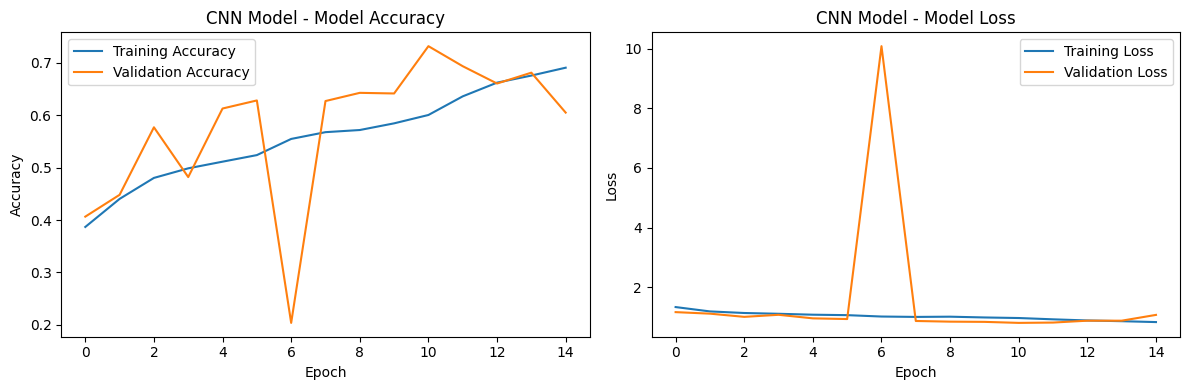

In [27]:
plot_training_history(cnn_history, "CNN Model")

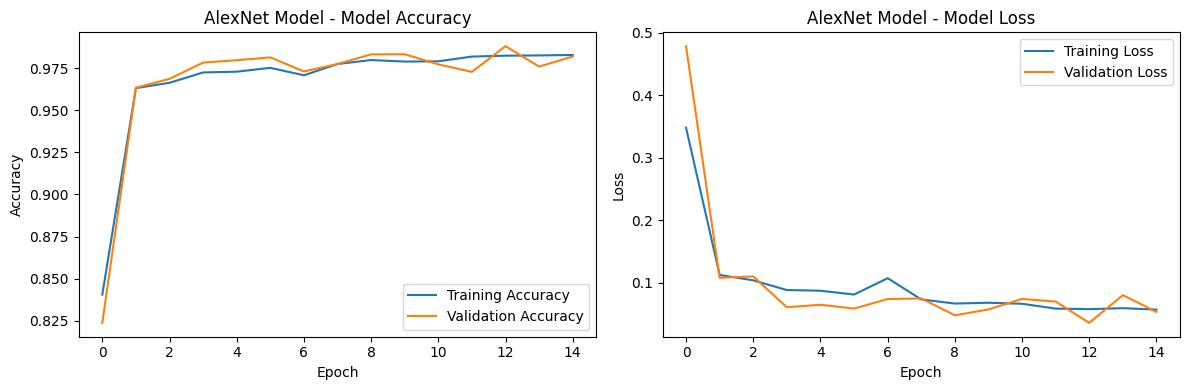

In [28]:
plot_training_history(alexnet_history, "AlexNet Model")

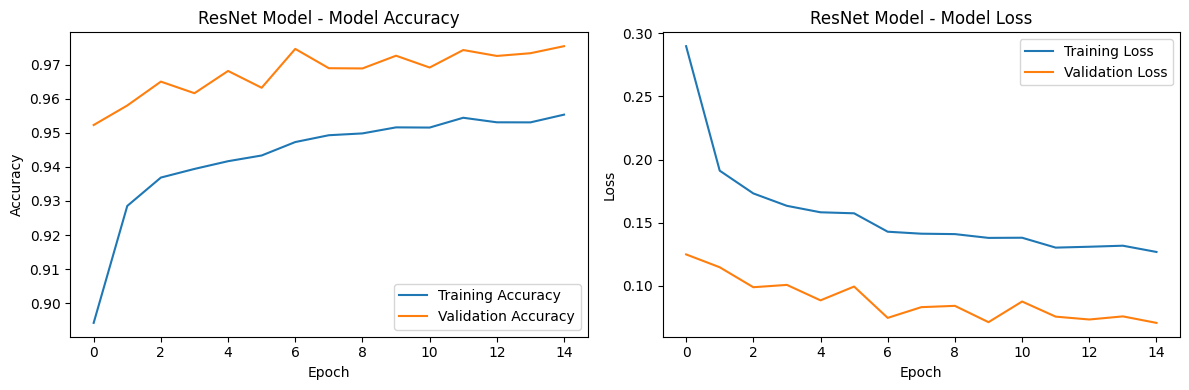

In [29]:
plot_training_history(resnet_history, "ResNet Model")

# t-SNE Visualization for Model Feature Maps

This step visualizes the learned feature representations from each model using **t-SNE** (t-Distributed Stochastic Neighbor Embedding) to reduce high-dimensional feature maps to 2D for better understanding:

- **Feature Extraction**: 
  - Features are extracted from the global average pooling layer of each model (`gap_name` parameter).
  
- **t-SNE Transformation**: 
  - The high-dimensional features are transformed into 2D using t-SNE, making it easier to visualize and understand how the models cluster data.

- **Visualization**:
  - **Scatter plots** display the data points in 2D space, with colors corresponding to different classes.

Plots are generated for:
1. **CNN Model**: Feature maps extracted from `global_average_pooling2d`.
2. **AlexNet Model**: Feature maps from `global_average_pooling2d_1`.
3. **ResNet50 Model**: Feature maps from `global_average_pooling2d_2`.

These visualizations help assess the separability of the classes based on the learned features.


In [30]:
# Load best models
cnn_model.load_state_dict(torch.load("best_cnn.pth"))
alexnet_model.load_state_dict(torch.load("best_alexnet.pth"))
resnet50_model.load_state_dict(torch.load("best_resnet50.pth"))

<All keys matched successfully>

In [31]:
# Feature extraction for t-SNE
def extract_features_and_labels(model, data_loader, layer_name=None):
    model.eval()
    features = []
    labels = []
    
    # Hook to extract features from specific layer
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    
    # Register hook based on model type
    if isinstance(model, CNNModel):
        model.global_pool.register_forward_hook(get_activation('features'))
    elif isinstance(model, AlexNetModel):
        model.global_pool.register_forward_hook(get_activation('features'))
    else:  # ResNet50
        model.avgpool.register_forward_hook(get_activation('features'))
    
    with torch.no_grad():
        for inputs, batch_labels in data_loader:
            inputs = inputs.to(device)
            _ = model(inputs)
            
            # Get features from the hook
            batch_features = activation['features'].view(activation['features'].size(0), -1)
            features.append(batch_features.cpu().numpy())
            labels.append(batch_labels.numpy())
    
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    return features, labels

In [32]:
def plot_tsne(model, title):
    features, labels = extract_features_and_labels(model, test_loader)
    
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(50, len(features)//4))
    features_tsne = tsne.fit_transform(features_scaled)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], 
                         c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title(f"t-SNE Visualization for {title}")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    
    # Add legend
    unique_labels = np.unique(labels)
    for i, label in enumerate(unique_labels):
        plt.scatter([], [], c=plt.cm.viridis(i/len(unique_labels)), 
                   label=classes[label] if label < len(classes) else f'Class {label}')
    plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_19/1771594968.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=plt.cm.viridis(i/len(unique_labels)),


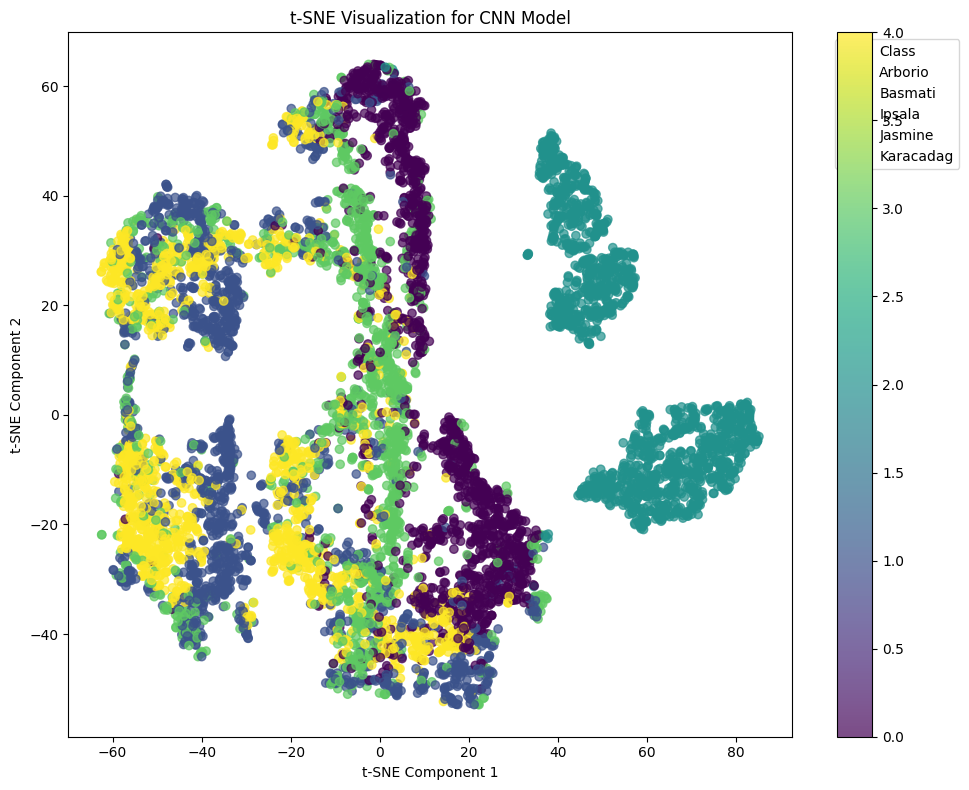

In [33]:
plot_tsne(cnn_model, "CNN Model")

/tmp/ipykernel_19/1771594968.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=plt.cm.viridis(i/len(unique_labels)),


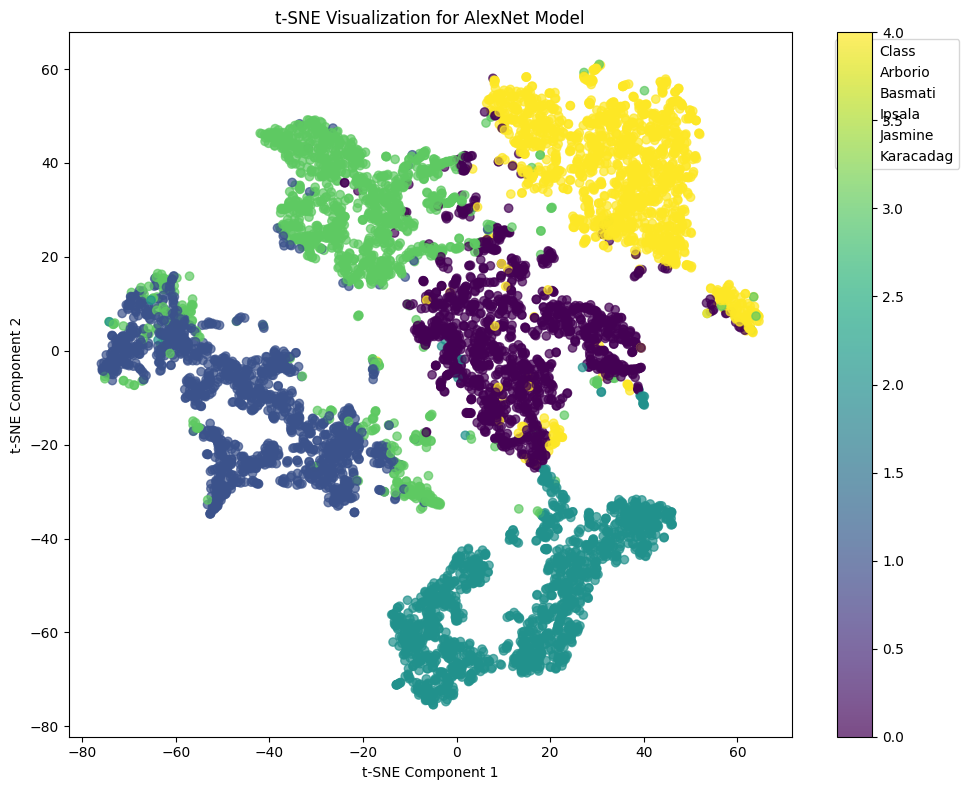

In [34]:
plot_tsne(alexnet_model, "AlexNet Model")

/tmp/ipykernel_19/1771594968.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=plt.cm.viridis(i/len(unique_labels)),


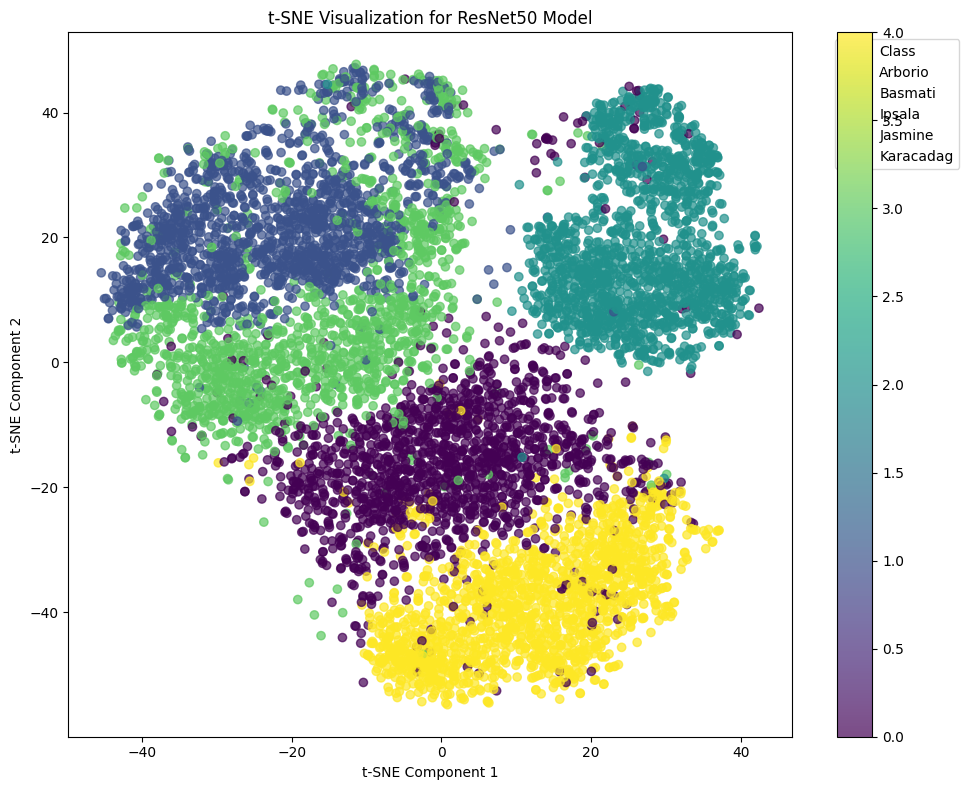

In [35]:
plot_tsne(resnet50_model, "ResNet50 Model")